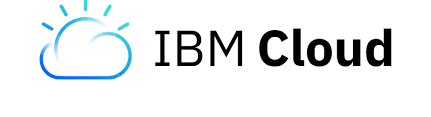

# OpenScale Tutorial

## First, let's start by creating the predictive model. 
This is a text classfier to predict customer churn based on movie reviews. We'll use the same data as we did in Module 4.

The input data is plain text of movie reviews. We'll first clean, tokenize and lemmatize the words, then convert them to a numeric matrix of tf-idf.

We'll do this in two parts, so that the deployed model can have a numeric feature matrix as its input.

In [ ]:
# Download the spacy English model
warnings.filterwarnings('ignore')
! python -m spacy download en_core_web_sm
# RESTART THE KERNEL AFTER RUNNING THIS CELL FOR THE FIRST TIME

In [ ]:
import os
import json
import sklearn
import sys
import pickle
import re
import pandas as pd
import numpy as np
import spacy
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'tagger', 'parser', 'textcat']) # we will only use the tokenizer.
from sklearn.feature_extraction import text
from string import punctuation, printable
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix


DATA_DIR = "./data"

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# PASTE THE ID OF YOUR DEPLOYEMENT SPACE
SPACE_ID = "385d623c-f899-4e5e-a0e5-4c6e0cea8f16"



#385d623c-f899-4e5e-a0e5-4c6e0cea8f16 space id

In [ ]:
movie_reviews = pd.read_csv(os.path.join(DATA_DIR, 'past_movie_reviews.csv'))
movie_reviews.head()

In [ ]:
X = movie_reviews['review']
y = movie_reviews['label'].rename('*label*')

# The target column must have a name that does not appear as a word/token in the corpus

In [ ]:
# clean up and convert the plain text 
warnings.filterwarnings('ignore')
def lemmatize(doc):    
    doc = str(doc).lower()
    doc = re.sub(r'[^ a-z]', '', doc)
    doc = nlp(doc)
    tokens = [re.sub("\W+", "", token.lemma_.lower()) for token in doc ]
    return ' '.join(w for w in tokens if (len(w)>1))

#X = X.apply(lemmatize)


In [10]:
print(X.head(10))

0    bcan you say dated nyou can if you ve seen ros...
1    bwhere do begin nokay how about with this star...
2    bseen december at at the crossgates mall cinem...
3    bcall hush stop or my mom will kill nor mommy ...
4    bwhy do people hate the spice girls what exact...
5    bthis independent film written and directed by...
6    virus is the type of cliched vacuous film that...
7    bsynopsis blond criminal psychologist sarah ch...
8    btempe mills cinema azthis movie had us in non...
9    bwell what are you going to expect nits movie ...
Name: review, dtype: object


# Some extra experimentation 

In [14]:
X.shape


(1000,)

In [15]:
pdf = pd.DataFrame(X,  index=X.index)

In [16]:
pdf.head(5)

,review
0,bcan you say dated nyou can if you ve seen ros...
1,bwhere do begin nokay how about with this star...
2,bseen december at at the crossgates mall cinem...
3,bcall hush stop or my mom will kill nor mommy ...
4,bwhy do people hate the spice girls what exact...


In [17]:
pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
review    1000 non-null object
dtypes: object(1)
memory usage: 7.9+ KB


In [69]:
pdf.to_csv('lemmatize_data_with_index.csv', encoding='utf-8', index=True)

In [66]:
pdf.to_csv('lemmatize_data_without_index.csv', encoding='utf-8', index=False)

In [70]:
import pandas as pd
df = pd.read_csv("lemmatize_data_without_index.csv")

In [71]:
df.head(5)

,review
0,bcan you say dated nyou can if you ve seen ros...
1,bwhere do begin nokay how about with this star...
2,bseen december at at the crossgates mall cinem...
3,bcall hush stop or my mom will kill nor mommy ...
4,bwhy do people hate the spice girls what exact...


In [72]:
y_pdf = pd.DataFrame(y,  index=y.index)

In [73]:
y_pdf.head(5)

,*label*
0,0
1,0
2,1
3,0
4,1


In [74]:
y_pdf.to_csv('y_lemmatize_data_without_index.csv', encoding='utf-8', index=False)

# Training split is done into train and test split: 

In [191]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

print(X_train.head(), X_test.head(), y_train.head(), y_test.head())

82     bnote some may consider portions of the follow...
991    flubber is the second best example of how to t...
789    bthe second serialkiller thriller of the month...
894    bthe release of dolores claiborne into wide re...
398    bmany people will not find much to like in wha...
Name: review, dtype: object 521    belmore leonard has quickly become one of holl...
737    bi know it already opened in december but fina...
740    bdeadbang an action thriller starring don john...
660    bstar wars episode the phantom menace ndirecto...
411    bingredients starving artist lusting after bea...
Name: review, dtype: object 82     1
991    0
789    0
894    1
398    1
Name: *label*, dtype: int64 521    1
737    1
740    0
660    0
411    1
Name: *label*, dtype: int64


In [192]:
# We vectorize the texts using a tfidf vectorizer
tf_idf = TfidfVectorizer(max_features = 10000, stop_words=text.ENGLISH_STOP_WORDS)

X_train_tfidf = tf_idf.fit_transform(X_train)
X_test_tfidf = tf_idf.transform(X_test)

In [193]:
X_train_tfidf

<750x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 163669 stored elements in Compressed Sparse Row format>

In [194]:
# Convert the tf-idf (numeric) array to a pandas dataframe with feature columns
X_train_df = pd.DataFrame(X_train_tfidf.toarray(), columns=tf_idf.get_feature_names(), index=X_train.index)
X_test_df = pd.DataFrame(X_test_tfidf.toarray(), columns=tf_idf.get_feature_names(), index=X_test.index )
X_train_df.head()

,aaron,abandon,abandoned,abandons,aberdeen,abilities,ability,able,aboard,abortion,...,zetajones,zingers,zoe,zombie,zombielike,zombies,zone,zoolander,zooms,zucker
82,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.024740,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025946,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### We have converted our plain text to a dense DataFrame of tf-idf for the top 10,000 terms. 

You will notice that nearly all of the cells are zero, and many of the words don't seem to be relevant to whether or not a customer is likely to churn. Words like "awful" and "wonderful" are likely correlated with customer satisfaction, but the implcation of words like 'zombie' and 'zoolander' are not as obvious.



In [136]:
print(y_train.index)

Int64Index([ 82, 991, 789, 894, 398, 323, 519, 916, 922,   5,
            ...
            121, 614,  20, 700,  71, 106, 270, 860, 435, 102],
           dtype='int64', length=750)


In [95]:
logreg = SGDClassifier(loss = 'log', max_iter = 100).fit(X_train_df, y_train)
print('Training score: ', logreg.score(X_train_df, y_train))
print('Test score: ', logreg.score(X_test_df, y_test))
print('Confusion Matrix: \n', confusion_matrix(y_test, logreg.predict(X_test_df), normalize = 'true'))


Training score:  1.0
Test score:  0.836
Confusion Matrix: 
 [[0.78740157 0.21259843]
 [0.11382114 0.88617886]]


In [96]:
NB = GaussianNB().fit(X_train_df, y_train)
print('Training score: ', NB.score(X_train_df, y_train))
print('Test score: ', NB.score(X_test_df, y_test))
print('Confusion Matrix: \n', confusion_matrix(y_test, NB.predict(X_test_df), normalize = 'true'))


Training score:  1.0
Test score:  0.644
Confusion Matrix: 
 [[0.5511811 0.4488189]
 [0.2601626 0.7398374]]


# Random forest classifier with cross validation :

In [198]:
from sklearn.ensemble import   RandomForestClassifier
from sklearn.ensemble import   GradientBoostingClassifier
import itertools

We observe that the model is over fitting. To reduce the complexity of the model, we will identify the 200 most significant words and rebuild a model just using these. Note that *most significant* does not mean most common -- it means the words that have the highest magnitude coefficient in the predictive model.

In [199]:
from sklearn.model_selection import LeaveOneGroupOut
logo = LeaveOneGroupOut()

In [200]:
num = np.random.choice([1, 2, 3, 4], size=(750,), p=[.25, .25, .25, .25])

In [ ]:
n_estimators_opt = [50, 100, 150, 300, 350, 400]
max_tree_depth_opt = range(2, 10)

accuracy_table = []

group = num
class_names = np.array(['negative'])

for n_estimators, max_tree_depth in itertools.product(n_estimators_opt, max_tree_depth_opt):
    # Iterate over each pair of hyperparameters
    cm = np.zeros((2, 2), dtype='int')                       # Create a new confusion matrix
    clf = RandomForestClassifier(n_estimators=n_estimators,  # and a new classifier  for each
                                 max_depth=max_tree_depth,   # pair of hyperparameters
                                 random_state=42,
                                 class_weight = "balanced"
                                )
    for train_ind, test_ind in logo.split(X_train_df, y_train, groups = num):
        #print(train_ind)
        #print(test_ind)
        # Do leave-one-subject-out cross validation as before.
        #X_train_indexes , y_train_indexes = indexs[train_ind] , indexs[train_ind]
       
        #X_test_indexes , y_test_indexes = indexs[test_ind] , indexs[test_ind]
        #print(len(X_train_indexes),  len(X_test_indexes))
        X_train_cv, y_train_cv = X_train_df.iloc[train_ind], y_train.iloc[train_ind]
        X_test_cv, y_test_cv = X_train_df.iloc[test_ind], y_train.iloc[test_ind]
        clf.fit(X_train_cv, y_train_cv)
        y_pred = clf.predict(X_test_cv)
        c = confusion_matrix(y_test_cv, y_pred)
        cm += c
        
    # For each pair of hyperparameters, compute the classification accuracy
    classification_accuracy = np.sum(np.diag(cm)) / np.sum(np.sum(cm))
    print( n_estimators, max_tree_depth, classification_accuracy)
    
    accuracy_table.append(("RandomForest",n_estimators, max_tree_depth, classification_accuracy))

In [209]:
accuracy_table_df = pd.DataFrame(accuracy_table,
                                 columns=["clf", 'n_estimators', 'max_tree_depth', 'accuracy'])
print(accuracy_table_df.head(10))


accuracy_table_df.to_csv("hyperparameters.csv" , index=False) 
accuracy_table_df.loc[accuracy_table_df.accuracy.idxmax()]
print("best hyperparameters : ", accuracy_table_df.loc[accuracy_table_df.accuracy.idxmax()])

            clf  n_estimators  max_tree_depth  accuracy
0  RandomForest            50               2  0.676000
1  RandomForest            50               3  0.700000
2  RandomForest            50               4  0.689333
3  RandomForest            50               5  0.692000
4  RandomForest            50               6  0.718667
5  RandomForest            50               7  0.716000
6  RandomForest            50               8  0.724000
7  RandomForest            50               9  0.690667
8  RandomForest           100               2  0.701333
9  RandomForest           100               3  0.693333
best hyperparameters :  clf               RandomForest
n_estimators               400
max_tree_depth               6
accuracy                 0.776
Name: 44, dtype: object


## Using  the best hyperparameter form above with random forest classifier:

In [214]:
 RFCK = RandomForestClassifier(n_estimators=400,  # and a new classifier  for each
                                 max_depth=6,   # pair of hyperparameters
                                 random_state=42,
                                 class_weight = "balanced"
                                ).fit(X_train_df, y_train)

print('Training score: ', RFCK.score(X_train_df, y_train))
print('Test score: ', RFCK.score(X_test_df, y_test))
print('Confusion Matrix: \n', confusion_matrix(y_test, RFCK.predict(X_test_df), normalize = 'true'))


Training score:  0.9826666666666667
Test score:  0.808
Confusion Matrix: 
 [[0.81889764 0.18110236]
 [0.20325203 0.79674797]]


### Using the linear model to get the coef to check the the most import words effective  in the training:

In [211]:
indices_of_positive_features = np.argsort(logreg.coef_)[0][::-1][:100]
indices_of_negative_features = np.argsort(logreg.coef_)[0][:100]

vocabulary = np.array(tf_idf.get_feature_names())
positive_vocab = vocabulary[indices_of_positive_features]
negative_vocab = vocabulary[indices_of_negative_features]
print('20 most positive words: \n', positive_vocab[:20])
print('20 most negative words: \n', negative_vocab[:20])
significant_vocabulary = np.hstack([positive_vocab, negative_vocab])

20 most positive words: 
 ['great' 'hilarious' 'life' 'people' 'jackie' 'world' 'seen' 'pulp' 'wife'
 'excellent' 'father' 'reality' 'memorable' 'beautiful' 'normal' 'rocky'
 'chan' 'today' 'trek' 'titanic']
20 most negative words: 
 ['bad' 'worst' 'nt' 'boring' 'looks' 'waste' 'plot' 'like' 'lame' 'fails'
 'supposed' 'script' 'ntheres' 'awful' 'arnold' 'seagal' 'reason' 'wasted'
 'talent' 'action']


### Review of signficant words

A quick check of the word clouds for positive and negative words gives us confidence that our model is working as expected:

#### Positive Wordcloud
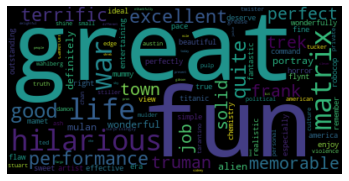


#### Negative Wordcloud
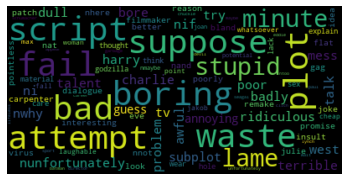


In terms of *Business Opportunity* these findings are not unexecpted. This provides important validation of a mathematical and measureable link between customer sentiment and business opportunities.


### Having found the most siginficant words, let us now build a TF-IDF Vectorizer focused only on these words

In [215]:
significant_tfidf = TfidfVectorizer(vocabulary = significant_vocabulary)

# Apply tfidf vectorizer
X_train_significant_tfidf = significant_tfidf.fit_transform(X_train)
X_test_significant_tfidf = significant_tfidf.transform(X_test)

# Save this trained TF-IDF Vectorizer for future use
with open('significant_tfidf.pkl', 'wb') as f:
    pickle.dump(significant_tfidf, f)

# Transtype to dataframes
X_train_significant_df = pd.DataFrame(X_train_significant_tfidf.toarray(), columns=significant_tfidf.get_feature_names(), index=X_train.index)
X_test_significant_df = pd.DataFrame(X_test_significant_tfidf.toarray(), columns=significant_tfidf.get_feature_names(), index=X_test.index )
X_train_significant_df.head()

,great,hilarious,life,people,jackie,world,seen,pulp,wife,excellent,...,lee,tv,nat,trying,day,bland,hard,embarrassing,subplot,harlem
82,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0000,0.0,0.0,0.000000,...,0.000000,0.0,0.145501,0.068605,0.000000,0.0,0.000000,0.0,0.000000,0.0
991,0.206210,0.0,0.064396,0.061998,0.0,0.0,0.0000,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.081826,0.0,0.089290,0.0,0.259723,0.0
789,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0000,0.0,0.0,0.000000,...,0.337428,0.0,0.000000,0.000000,0.000000,0.0,0.252122,0.0,0.000000,0.0
894,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0000,0.0,0.0,0.339265,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
398,0.050855,0.0,0.238219,0.091739,0.0,0.0,0.1604,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.062297,0.060540,0.0,0.066061,0.0,0.000000,0.0


### Save the training data, with `*label*` column. We will need this later.


In [216]:
pd.concat([X_train_significant_df, y_train], axis =1).to_csv(os.path.join(DATA_DIR, 'training_data.csv'), index = False)

### Let's now train a SGDClassifier using this smaller, more select data set and see how it performs

In [218]:
significant_logreg = SGDClassifier(loss = 'log', max_iter = 1000).fit(X_train_significant_df, y_train)
print('Training score: ', significant_logreg.score(X_train_significant_df, y_train))
print('Test score: ', significant_logreg.score(X_test_significant_df, y_test))
print('Confusion Matrix: \n', confusion_matrix(y_test, significant_logreg.predict(X_test_significant_df)))

Training score:  0.98
Test score:  0.796
Confusion Matrix: 
 [[105  22]
 [ 29  94]]


### Let's now train a Random Forest using this smaller, more select data set and see how it performs

On the test data, this preforms almost as well as the original model which had 10,000 feature words, but this one has only 200 feature words -- it uses 98% less data!

In [ ]:
significant_acc_table =[]
n_estimators_opt = [50, 100, 150, 300, 350, 400,500,600, 800]
max_tree_depth_opt = range(2, 15)

for n_estimators, max_tree_depth in itertools.product(n_estimators_opt, max_tree_depth_opt):
    # Iterate over each pair of hyperparameters
    cm = np.zeros((2, 2), dtype='int')       
    significant_RFCK = RandomForestClassifier(n_estimators=n_estimators,  # and a new classifier  for each
                                     max_depth=max_tree_depth,   # pair of hyperparameters
                                     random_state=42,
                                     class_weight = "balanced"
                                    ).fit(X_train_significant_df, y_train)
    
    
    

    print('Training score: ', significant_RFCK.score(X_train_significant_df, y_train))
    print('Test score: ', significant_RFCK.score(X_test_significant_df, y_test))
    #print('Confusion Matrix: \n', confusion_matrix(y_test, significant_RFCK.predict(X_test_significant_df)))
    
    
    
    c = confusion_matrix(y_test, significant_RFCK.predict(X_test_significant_df))
    cm = c
        
    # For each pair of hyperparameters, compute the classification accuracy
    classification_accuracy = np.sum(np.diag(cm)) / np.sum(np.sum(cm))
    #print( n_estimators, max_tree_depth, classification_accuracy)
    
    significant_acc_table.append(("sig_RandomForest",n_estimators, max_tree_depth, classification_accuracy))

In [238]:
sig_accuracy_table_df = pd.DataFrame(significant_acc_table,
                                 columns=["clf", 'n_estimators', 'max_tree_depth', 'accuracy'])
print(sig_accuracy_table_df.head(10))


sig_accuracy_table_df.to_csv("sig_hyperparameters.csv" , index=False) 
sig_accuracy_table_df.loc[sig_accuracy_table_df.accuracy.idxmax()]
print("best hyperparameters : ", sig_accuracy_table_df.loc[sig_accuracy_table_df.accuracy.idxmax()])

                clf  n_estimators  max_tree_depth  accuracy
0  sig_RandomForest            50               2     0.724
1  sig_RandomForest            50               3     0.736
2  sig_RandomForest            50               4     0.744
3  sig_RandomForest            50               5     0.752
4  sig_RandomForest            50               6     0.740
5  sig_RandomForest            50               7     0.764
6  sig_RandomForest            50               8     0.752
7  sig_RandomForest            50               9     0.780
8  sig_RandomForest            50              10     0.788
9  sig_RandomForest            50              11     0.776
best hyperparameters :  clf               sig_RandomForest
n_estimators                   150
max_tree_depth                  14
accuracy                     0.792
Name: 38, dtype: object


In [246]:
significant_RFCK = RandomForestClassifier(n_estimators=150,  # and a new classifier  for each
                                     max_depth=14,   # pair of hyperparameters
                                     random_state=42,
                                     class_weight = "balanced"
                                    ).fit(X_train_significant_df, y_train)
    
    
    

print('Training score: ', significant_RFCK.score(X_train_significant_df, y_train))
print('Test score: ', significant_RFCK.score(X_test_significant_df, y_test))
print('Confusion Matrix: \n', confusion_matrix(y_test, significant_RFCK.predict(X_test_significant_df)))

Training score:  0.9813333333333333
Test score:  0.792
Confusion Matrix: 
 [[100  27]
 [ 25  98]]


### Now that we have a reasonably good model, let's deploy it to IBM Watson ML
You should already have an account with Watson Studio and credentials saved in ```~/.ibm/wml.json```.

If you need to create these credentials, please revisit the tutorial in Module 5


In [239]:
# Import credentials from ~/.ibm/wml.json
wmlcreds_file = os.path.join(os.path.expanduser("~"),'.ibm/wml.json')
print(wmlcreds_file)
# or set location of file manually:
wmlcreds_file = wmlcreds_file #replace with location of file if different than ~/.ibm/wml.json
with open(wmlcreds_file, "r") as wml_file:
        wmlcreds = json.load(wml_file)

# convert credentials to the correct dictoinary format
wml_credentials = {"apikey": wmlcreds['apikey'],
    "url": wmlcreds['url']}

print(wml_credentials)


C:\Users\abhishek buragohaibn\.ibm/wml.json
{'apikey': 'GVNz4CC5C9cjKVwwpfXV_vBrxinvXeezRK1Fvw7yr9Mc', 'url': 'https://us-south.ml.cloud.ibm.com'}


#### Create a client to interact with Watson Machine Learning

In [240]:
from ibm_watson_machine_learning import APIClient
client = APIClient(wml_credentials)
client.set.default_space(SPACE_ID)
print(client)

#### Review deployed models and delete any unused models to make room for new deployments

In [241]:
# list deployements
client.deployments.list()
# guid = 'Insert guid to delete here'
# client.deployments.delete(guid)

------------------------------------  -----------------  -----  ------------------------
GUID                                  NAME               STATE  CREATED
43a519b0-e866-4b65-aec3-6fff62ecbd72  model1_deployment  ready  2021-04-16T15:25:26.313Z
------------------------------------  -----------------  -----  ------------------------


In [247]:
# list models
client.repository.list()
# guid = 'Insert guid to delete here'
# client.repository.delete(guid)

------------------------------------  -------------------  ------------------------  -----------------  -----
GUID                                  NAME                 CREATED                   FRAMEWORK          TYPE
90fa5e29-021a-4fc7-b591-9e376e927e24  Model5_randomforest  2021-04-17T21:12:44.002Z  scikit-learn_0.23  model
29188fae-2563-436e-9a6c-83d121180aba  Model4               2021-04-16T15:24:52.002Z  scikit-learn_0.23  model
1960b96c-36fd-4608-98a0-ffa60ca70b5b  Model2               2021-04-16T15:09:20.002Z  scikit-learn_0.22  model
e67ee397-71c9-467f-8e3c-231872dc18ec  Model1               2021-04-16T15:05:02.002Z  scikit-learn_0.22  model
053f0fae-dc0e-43e3-8d10-ed2460f828ed  model_WML_tuto       2021-01-29T21:11:20.002Z  scikit-learn_0.22  model
ab76fb0c-1c57-4543-b211-afaed2b87db3  model_WML_tuto       2021-01-29T19:27:53.002Z  scikit-learn_0.22  model
e282841e-f206-4086-91e7-16826c511b08  model_WML_tuto       2021-01-29T19:25:46.002Z  scikit-learn_0.22  model
75e68ecc-3d

#### Let's store the Model in the repository

In [243]:
significant_logreg

SGDClassifier(loss='log')

In [248]:
significant_RFCK

RandomForestClassifier(class_weight='balanced', max_depth=14, n_estimators=150,
                       random_state=42)

In [253]:
#default_py3.7
software_spec_uid = client.software_specifications.get_uid_by_name("default_py3.7")
meta_props = {
       client.repository.ModelMetaNames.NAME: 'Model7_randomforest',
       client.repository.ModelMetaNames.TYPE: 'scikit-learn_0.23',
       client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid
}

model_details = client.repository.store_model(significant_RFCK, meta_props)
model_uid = client.repository.get_model_uid(model_details)

client.repository.list_models()

------------------------------------  -------------------  ------------------------  -----------------
ID                                    NAME                 CREATED                   TYPE
e23e9c61-2731-45c3-b0bc-064eae94dce4  Model7_randomforest  2021-04-17T21:17:00.002Z  scikit-learn_0.23
f0b5d65f-a647-46d5-83df-0010283197b6  Model6_randomforest  2021-04-17T21:15:22.002Z  scikit-learn_0.23
005ece87-a30e-41ba-80b4-6cc251cfb8f6  Model5_randomforest  2021-04-17T21:14:56.002Z  scikit-learn_0.23
90fa5e29-021a-4fc7-b591-9e376e927e24  Model5_randomforest  2021-04-17T21:12:44.002Z  scikit-learn_0.23
29188fae-2563-436e-9a6c-83d121180aba  Model4               2021-04-16T15:24:52.002Z  scikit-learn_0.23
1960b96c-36fd-4608-98a0-ffa60ca70b5b  Model2               2021-04-16T15:09:20.002Z  scikit-learn_0.22
e67ee397-71c9-467f-8e3c-231872dc18ec  Model1               2021-04-16T15:05:02.002Z  scikit-learn_0.22
053f0fae-dc0e-43e3-8d10-ed2460f828ed  model_WML_tuto       2021-01-29T21:11:20.002Z  s

In [254]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.23.0.


#### And now we deploy the model

In [255]:
meta_props = {
    client.deployments.ConfigurationMetaNames.NAME: "model7_randomforest_deployment",
    client.deployments.ConfigurationMetaNames.ONLINE: {}
    }


deployment_details = client.deployments.create(model_uid, meta_props)

deployment_id = deployment_details['metadata']['id']
print(deployment_id)



#######################################################################################

Synchronous deployment creation for uid: 'e23e9c61-2731-45c3-b0bc-064eae94dce4' started

#######################################################################################


initializing
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='6ec55e26-23cc-41dd-b160-8e1c3ac331c9'
------------------------------------------------------------------------------------------------


6ec55e26-23cc-41dd-b160-8e1c3ac331c9


In [256]:
# print the status of the deployment
print(deployment_details['entity']['status'])

{'online_url': {'url': 'https://us-south.ml.cloud.ibm.com/ml/v4/deployments/6ec55e26-23cc-41dd-b160-8e1c3ac331c9/predictions'}, 'state': 'ready'}


### Let's verify the deployment by sending it some data and getting a response

Let's send it a movie review and see if it thinks we are likely to churn.

In [257]:
good_review = "This movie is really good. I really liked it. I want to watch it again. Excellent!"

#### Lemmatize and vectorize the text.
As before, we can't just send plain text like this. It needs to be cleaned, lemmatized and converted to a tf-idf numeric matrix, using the same methods that the model was first trained on

In [258]:
good_review = lemmatize(good_review)
good_review = significant_tfidf.transform([good_review]).todense()
good_review = pd.DataFrame(good_review)
good_review.columns = significant_tfidf.vocabulary_
print(good_review.head())

[2021-04-17 23:17:38,788] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'this'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-04-17 23:17:38,788] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'movie'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-04-17 23:17:38,797] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'is'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-04-17 23:17:38,797] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'really'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-04-17 23:17:38,79

   great  hilarious  life  people  jackie  world  seen  pulp  wife  excellent  \
0    0.0        0.0   0.0     0.0     0.0    0.0   0.0   0.0   0.0   0.914957   

   ...  lee   tv  nat  trying  day  bland  hard  embarrassing  subplot  harlem  
0  ...  0.0  0.0  0.0     0.0  0.0    0.0   0.0           0.0      0.0     0.0  

[1 rows x 200 columns]


#### We can now create a data payload and send this to the deployed model for prediction

In [259]:
values = good_review.values.tolist()
payload = {client.deployments.ScoringMetaNames.INPUT_DATA:
           [
               {'fields':list(significant_tfidf.vocabulary_), 
                'values': values}
           ]
          }

prediction = client.deployments.score(deployment_id, payload)
print(prediction)

{'predictions': [{'fields': ['prediction', 'probability'], 'values': [[1, [0.1920757995180263, 0.8079242004819733]]]}]}


#### Let's do the same with a bad movie review

In [260]:
bad_review = "I really hated this bad movie. it was awful. I want to quit. Horrible. terrible"
bad_review = lemmatize(bad_review)
bad_review = significant_tfidf.transform([bad_review]).todense()
bad_review = pd.DataFrame(bad_review)
bad_review.columns = significant_tfidf.vocabulary_
print(bad_review.head())

[2021-04-17 23:18:20,972] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'i'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-04-17 23:18:20,975] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'really'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-04-17 23:18:20,977] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'hated'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-04-17 23:18:20,979] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'this'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-04-17 23:18:20,982

   great  hilarious  life  people  jackie  world  seen  pulp  wife  excellent  \
0    0.0        0.0   0.0     0.0     0.0    0.0   0.0   0.0   0.0        0.0   

   ...  lee   tv  nat  trying  day  bland  hard  embarrassing  subplot  harlem  
0  ...  0.0  0.0  0.0     0.0  0.0    0.0   0.0           0.0      0.0     0.0  

[1 rows x 200 columns]


In [261]:
values = bad_review.values.tolist()
payload = {client.deployments.ScoringMetaNames.INPUT_DATA:
           [
               {'fields': list(significant_tfidf.vocabulary_), 
                'values': values}
           ]
          }

prediction = client.deployments.score(deployment_id, payload)
print(prediction)

{'predictions': [{'fields': ['prediction', 'probability'], 'values': [[0, [0.6758025027528802, 0.32419749724712027]]]}]}


As you can see, we get a very different prediction for the bad review.

## OpenScale Configuration
### The next step is to link this deployed model to IBM Watson OpenScale to provide monitoring services

To get started, navigate to your `Dashboard` at https://cloud.ibm.com/

At the upper right, click on `Create Resource`. This will take you to the catalog of services offered in the IBM Watson Suite. We'll be using ``Watson OpenScale``, but you might want to take a minute to examine some of the many other offerings.

You can also use this link to take you directly to the OpenScale service: 

https://cloud.ibm.com/catalog/services/watson-openscale

### Create the service
If you're using the free lite plan, accept the default. You may change the `Service name` if you wish. In this example, I am calling my service `'OS-tutorial'`

On the right, click `Create` then scroll on the top of the page and click on `manage` in the top left of the page. Click on `'Launch Applicaton'` to Launch OpenScale.

### Setting up the service
You should now see the welcome message as shown below.

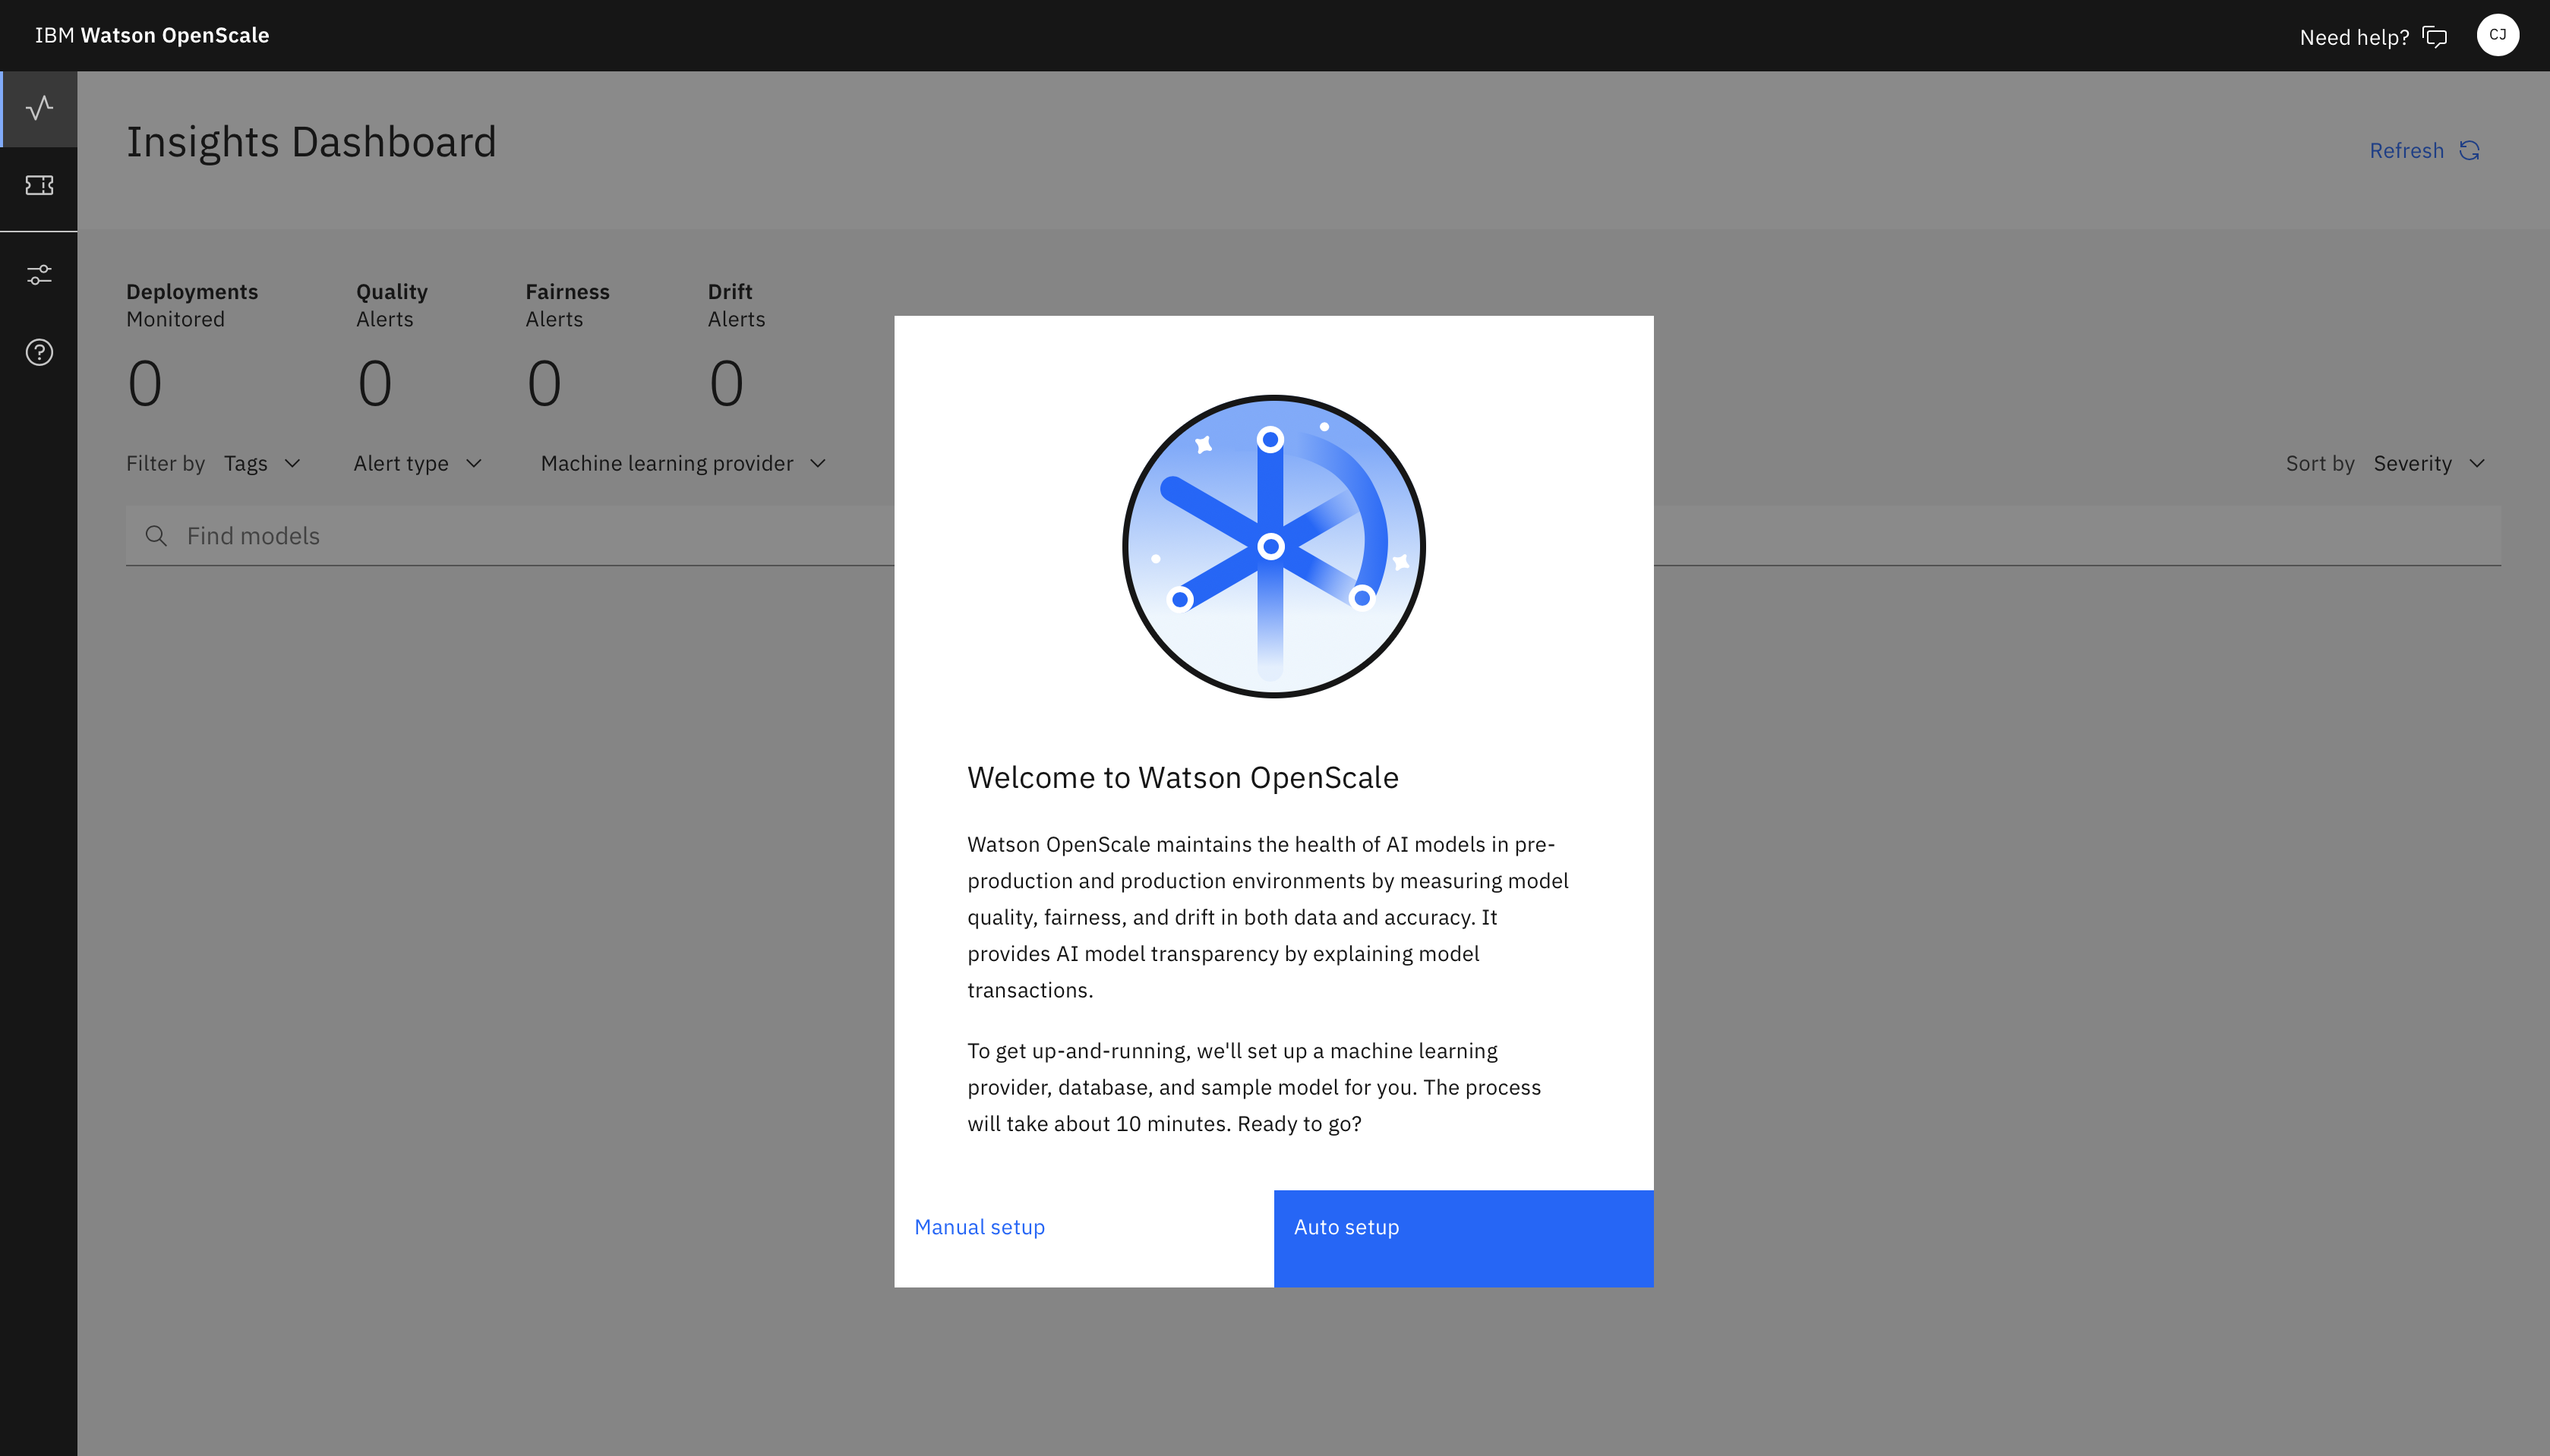

Click on `Manual setup`

#### We first need to connect a database to the service.

Connecting a database to the service allows some memory space for the service.
Click on the pencil icon on the top right of the card.

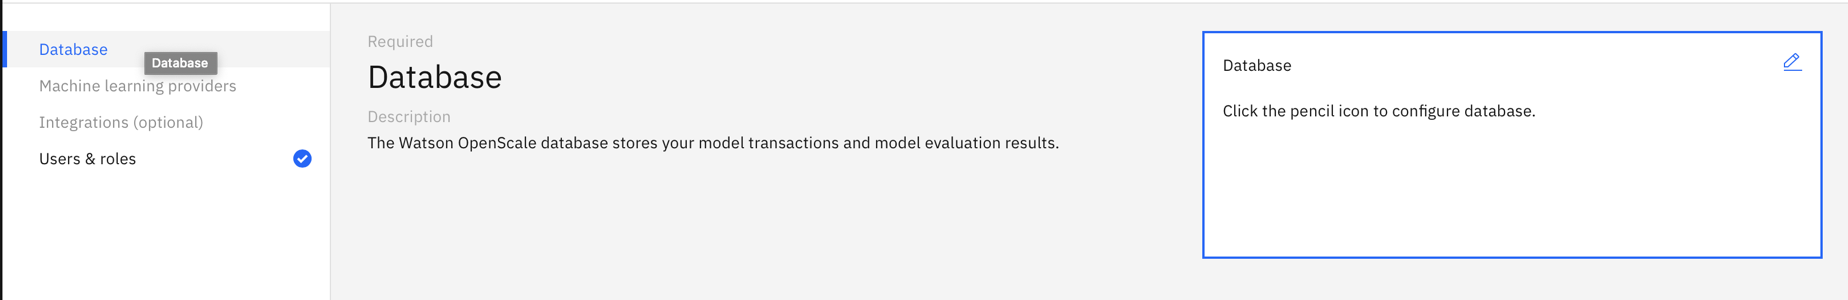

Choose the option `"Free lite plan database"` and `save`.

#### Setup Machine learning provider

You can now click on `Machine learning providers` below Database on the right of your screen. Then click on `Add Machine Learning Provider`. Click on the pencil icon on the top right of the card.

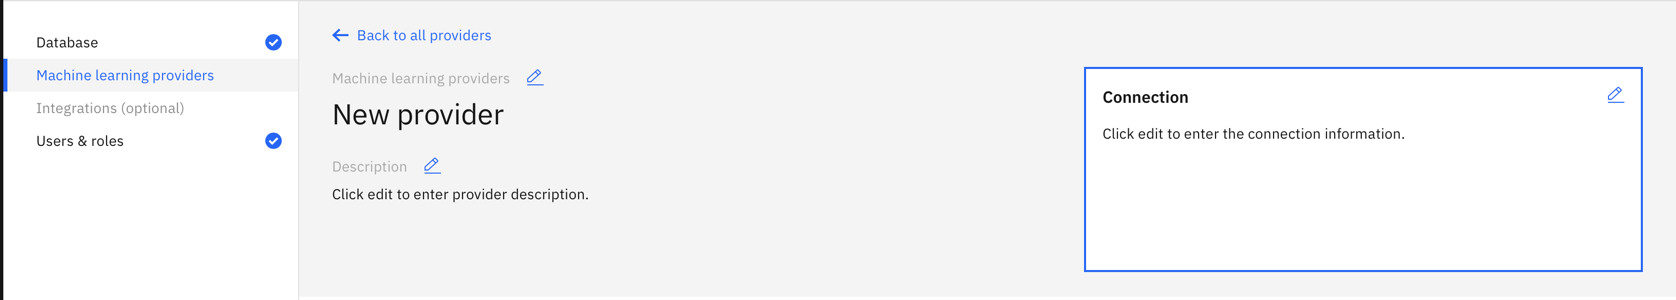


Choose `Watson Machine Learning (V2)` then select the deployment space that you created before starting this notebook and save.


### Add and configure a model deployment

Now that the instance is properly setup we can add a model deployment. We will simply connect the deployment of the model we did above to the OpenScale instance.

#### Add a model deployment

First, go to the Dashboard clicking on dashboard icon top right of your screen.
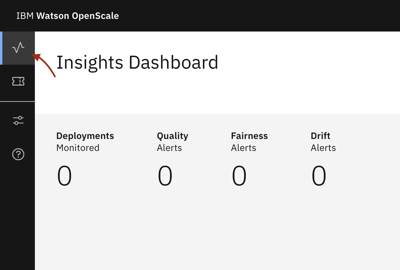

Click on `Add to dashboard +` then select the deployment and click on `Configure`. Click on `Configure monitors`

#### Configure model input

Here we will configure the type of input and the type of Algorithm. click on the pencil icon on the top right of the "Model input" card.

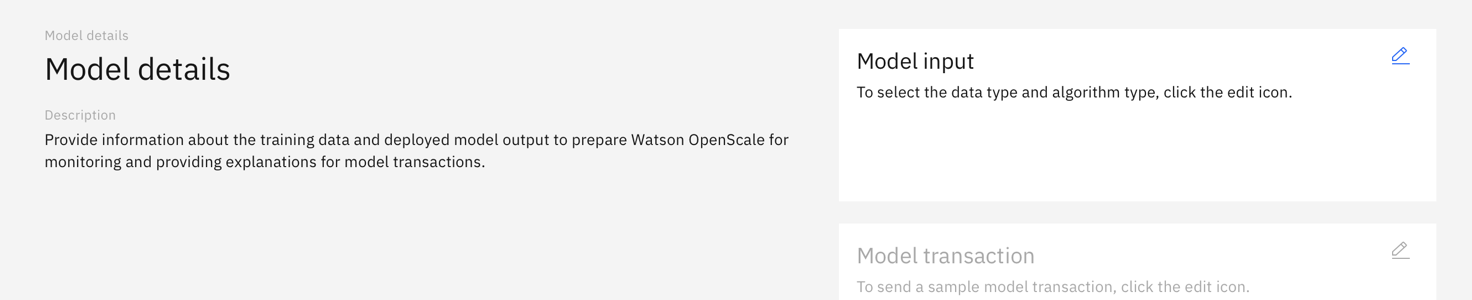

Under Data type select `Numerical/categorical` and select `Binary classification` under Algorithm type then save.

#### Add a connection to the training data

The next step is to provide to the OpenScale instance the training data. We will first need to save the training data to a `Cloud Object Storage` . 

Since creating a Watson machine learning service require a cloud storage, you should already have a `Cloud Object Storage` object in the resources of your IBM Cloud account : https://cloud.ibm.com/resources 

In the list of your resources and under `Storage` click on the name of your `Cloud Object Storage`. We will create a bucket to store our training data.

Click on `Create bucket +`

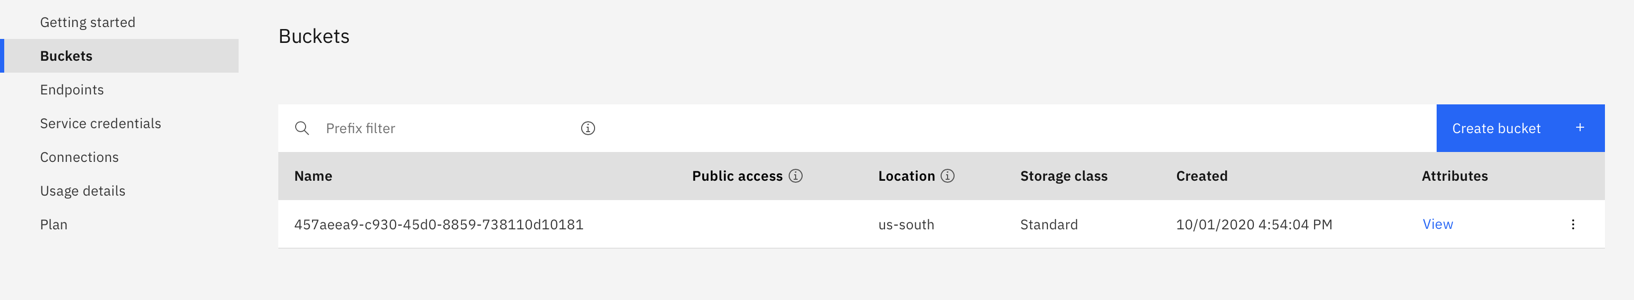

Select `Custom Bucket`. There are 3 custom parameters to specify :


* Give a name to your bucket
* Under **Resiliency** select `Cross Region`
* Under **Location** select your location

Leave the other options as default.

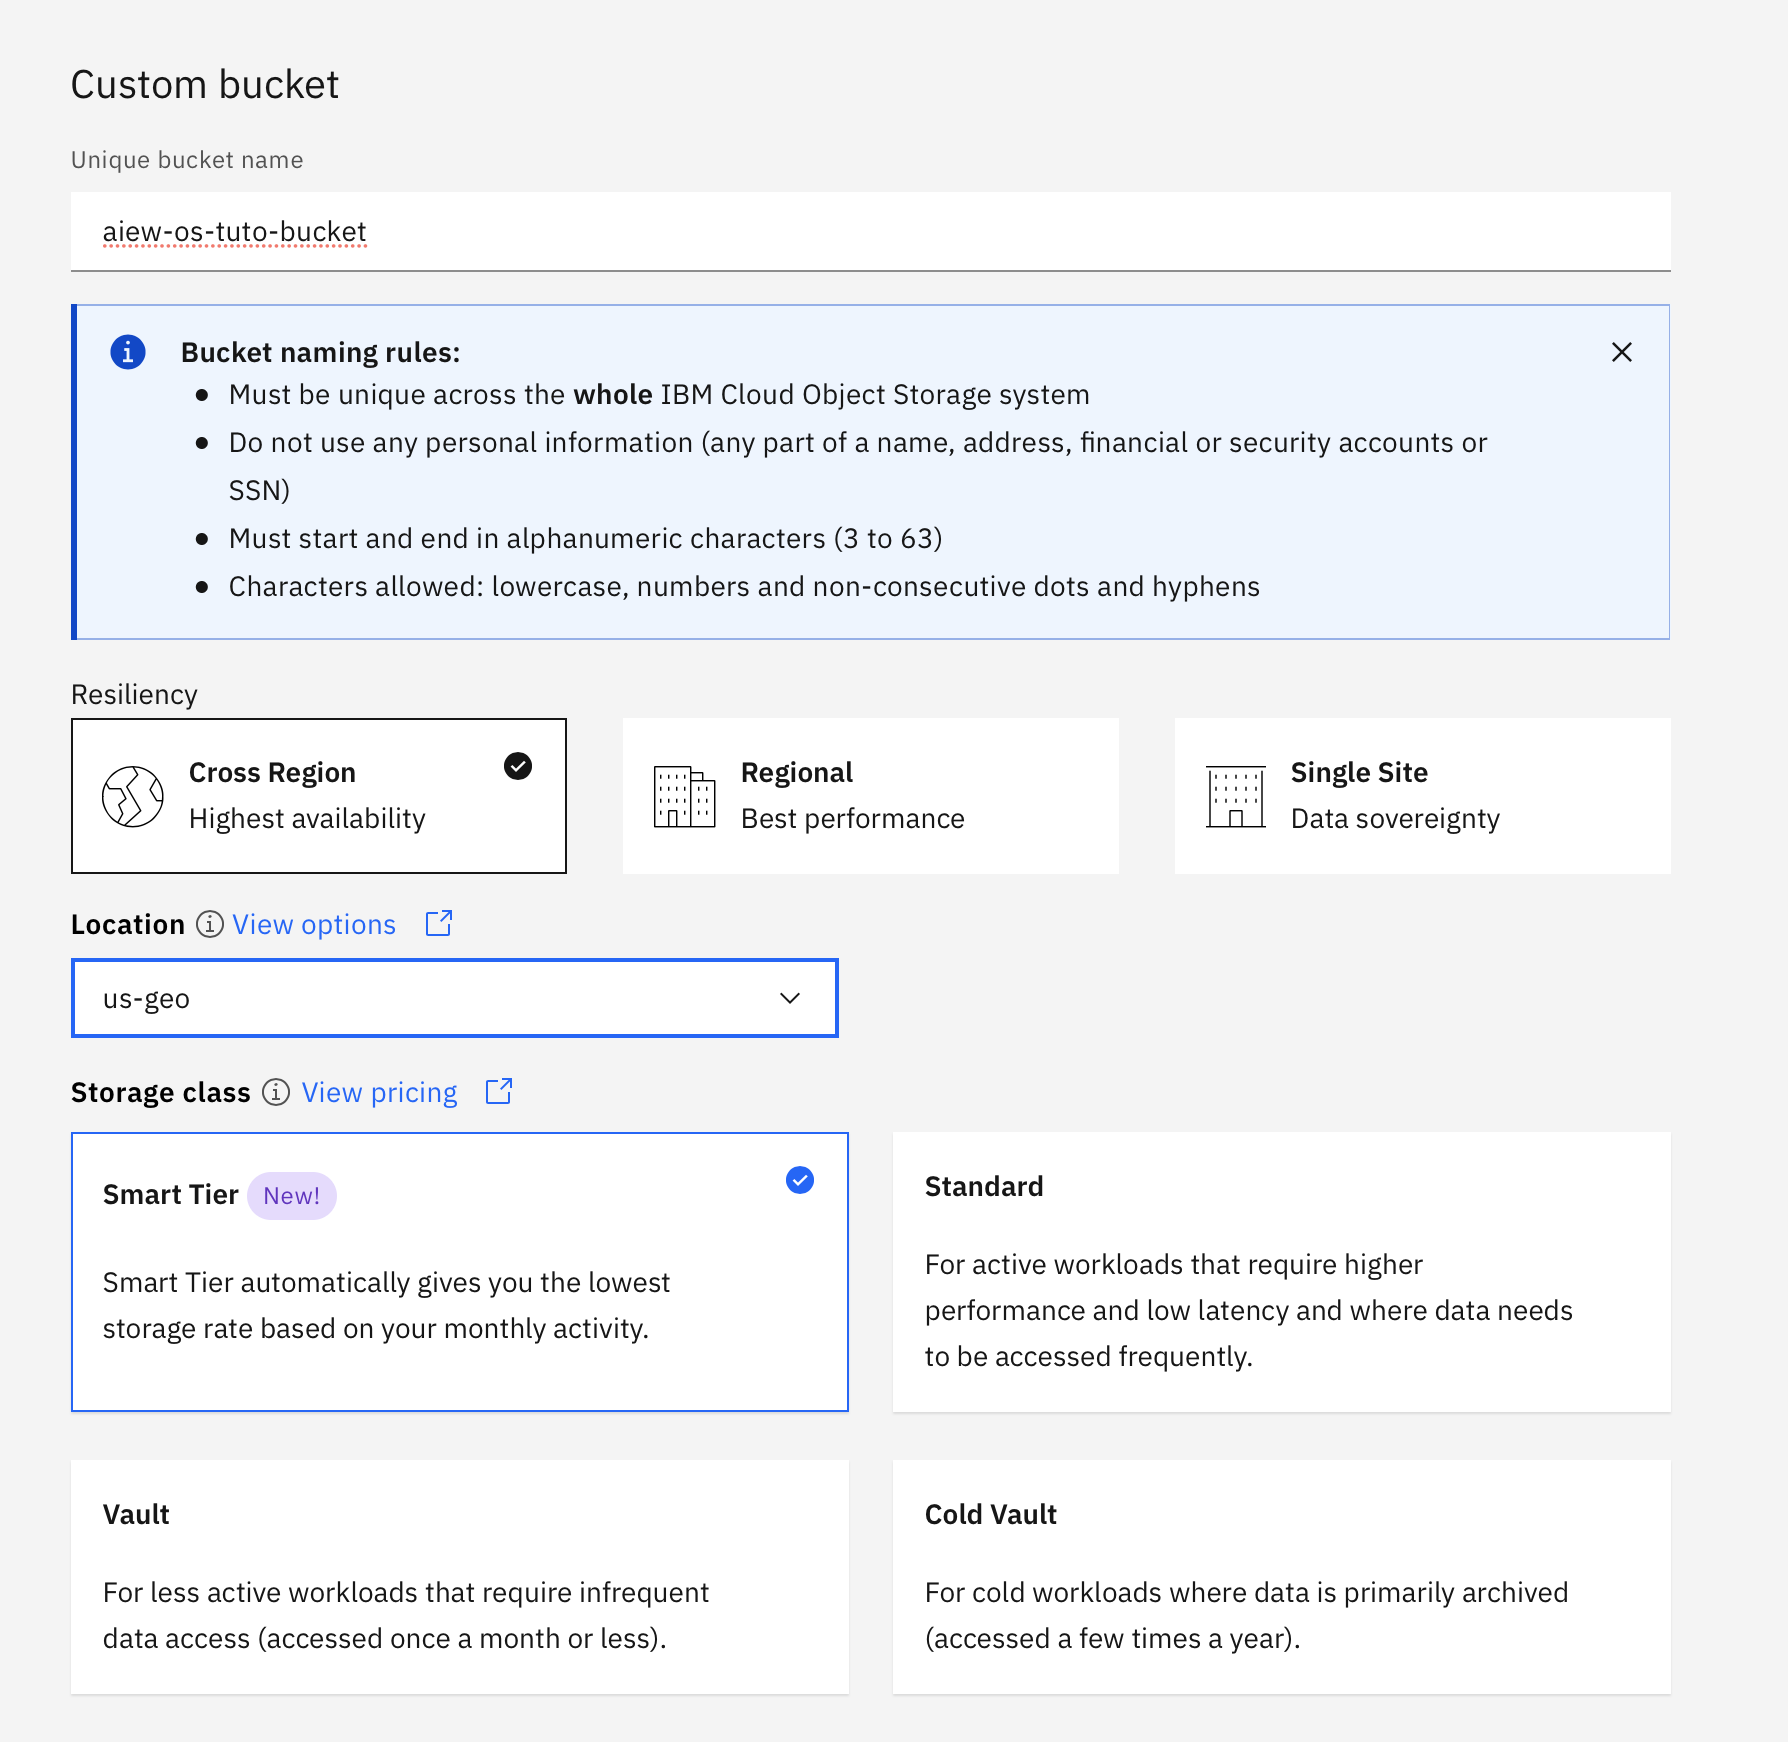

Scroll down and click on `Create Bucket`. We now have a brand new bucket let's populate it with the training data. Drag and drop the csv file `training_data` that we created earlier in this notebook.

At this stage the training data is stored in a bucket of a Cloud Object Storage. In order to communicate the training data to the OpenScale instance we need to allow the OpenScale instance to access this bucket. To do so, we will need to pass the credentials of our Cloud Object storage to the OpenScale instance. 

On the main menu bar of the Cloud Object Storage click on `Service Credentials`.

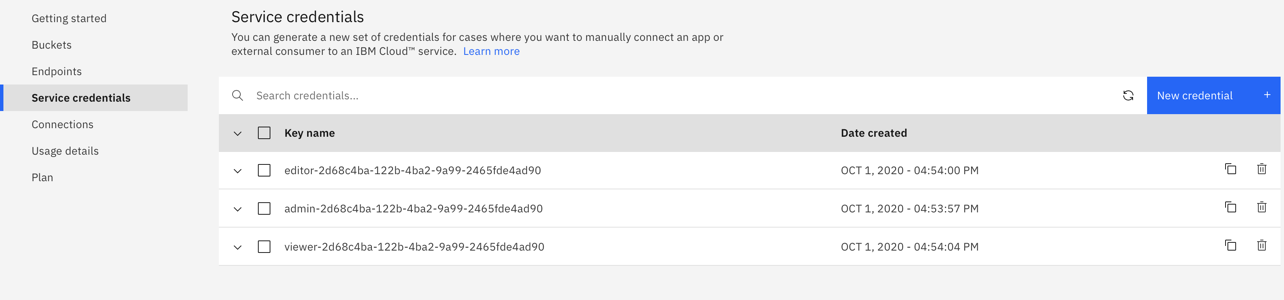



Expand the credentials with the prefix `editor` and copy past these credentials in a .txt file. We will need these credentials in a minute.


We are done with the bucket! lets go back to the configuration of our OpenScale instance. Go back to the configuration page of your OpenScale instance and click on the pencil on the top right of the "Training data" card.

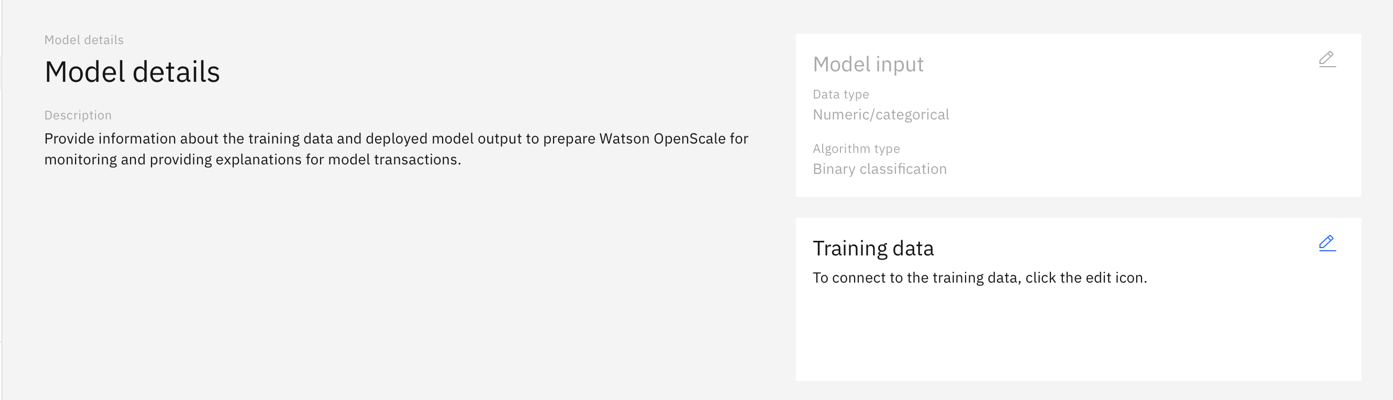

* Under `Storage Type` select `Database or cloud storage`
* Under `Location` select `Cloud Object Storage`
* Copy and paste the `Resource instance ID` and the `API key` from the credentials of your Cloud Object Storage and click on connect
* Then select your bucket, training_data.csv and click on Next

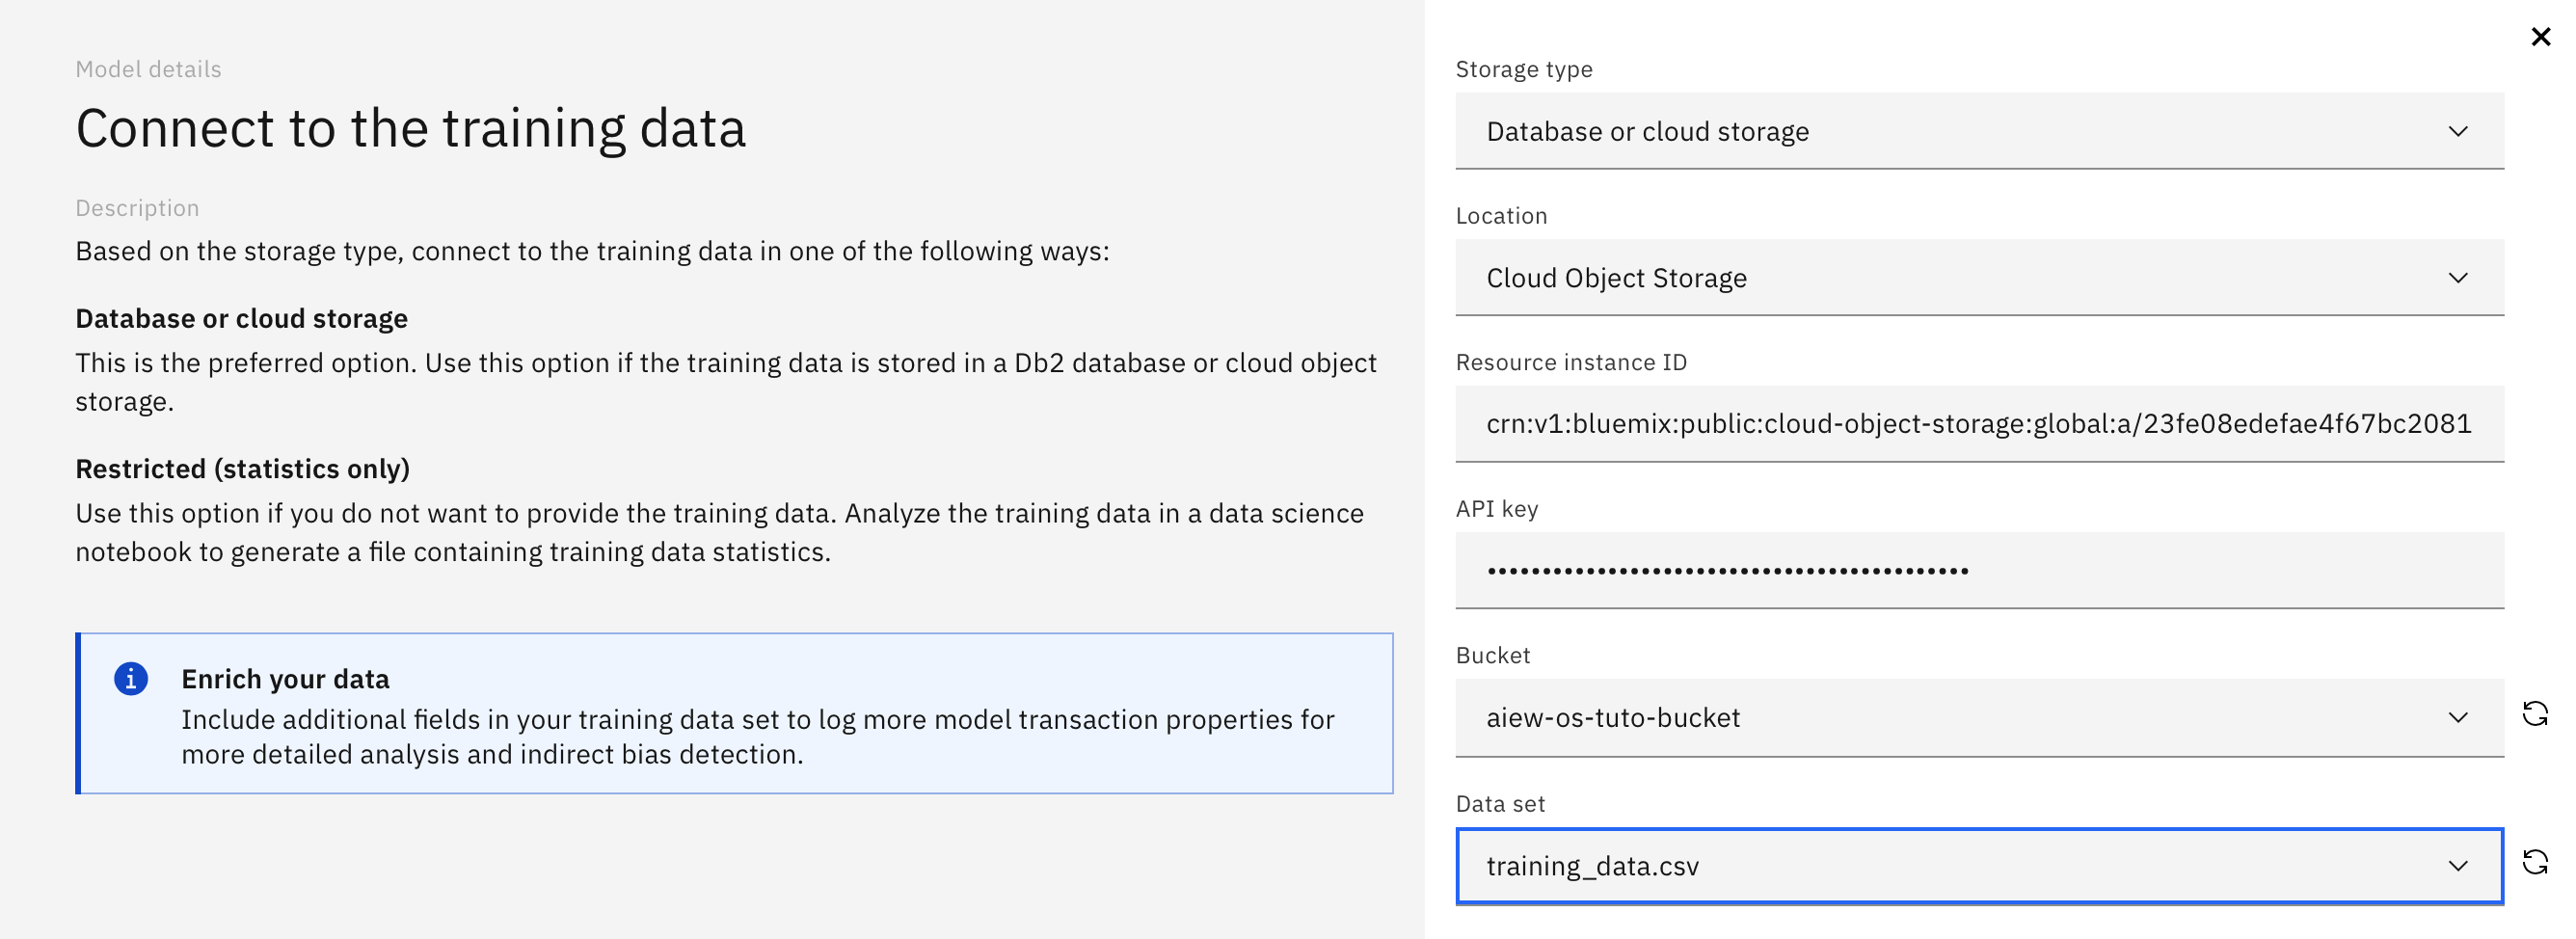


The next step is to specify the name of the label and the name of the features. Select `*label*` as the label column and click next. Select `Features (200)` to select all the features and click next.

### Examining model output

OpenScale needs to examine the output of the model. Under `Scoring methods` select `Payload logging API` and Under `Code language` select `Python`. We now need to request a scoring from this notebook. We'll use the same payload as above.

In [264]:
# Send the payload for scoring and print the results
prediction = client.deployments.score(deployment_id, payload)
print(prediction)

{'predictions': [{'fields': ['prediction', 'probability'], 'values': [[0, [0.6758025027528802, 0.32419749724712027]]]}]}


Return to the OpenScale configuration page and click on `Check Now`. Click on `Next`.

### Specify model output details

Select both prediction and probability and click on `Save`.

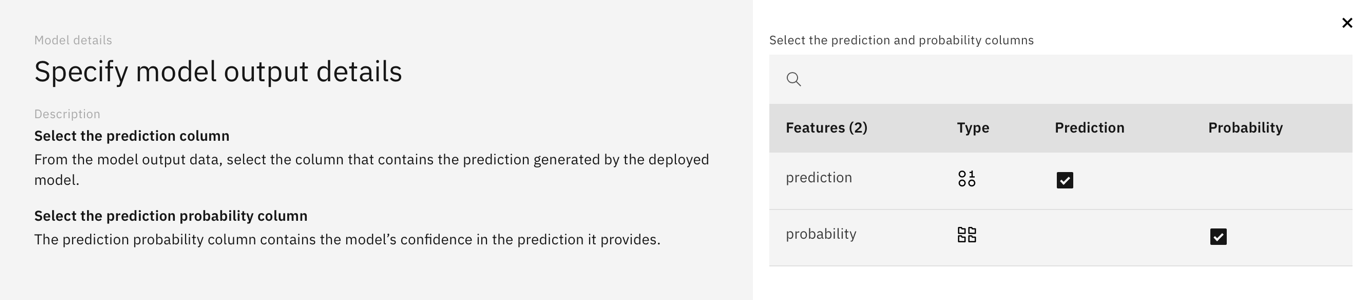

### Configure Drift Monitor

The OpenScale instance is now ready to monitor our model deployment. In the current state only the explainability monitoring feature is active. Further configuration is required to enable the monitoring of Fairness, drift and quality. 

The input to our model is plain text. We have not collected demographic information such as race, gender or nationality, so the Fairness monitoring tool is not applicable to this tutorial. 

We will use the Drift monitoring tool to monitor the deployed model over time.

Select `Drift` from the column at left and then click on the pencil icon on the top right of the `Drift Model` card to start the configuration.

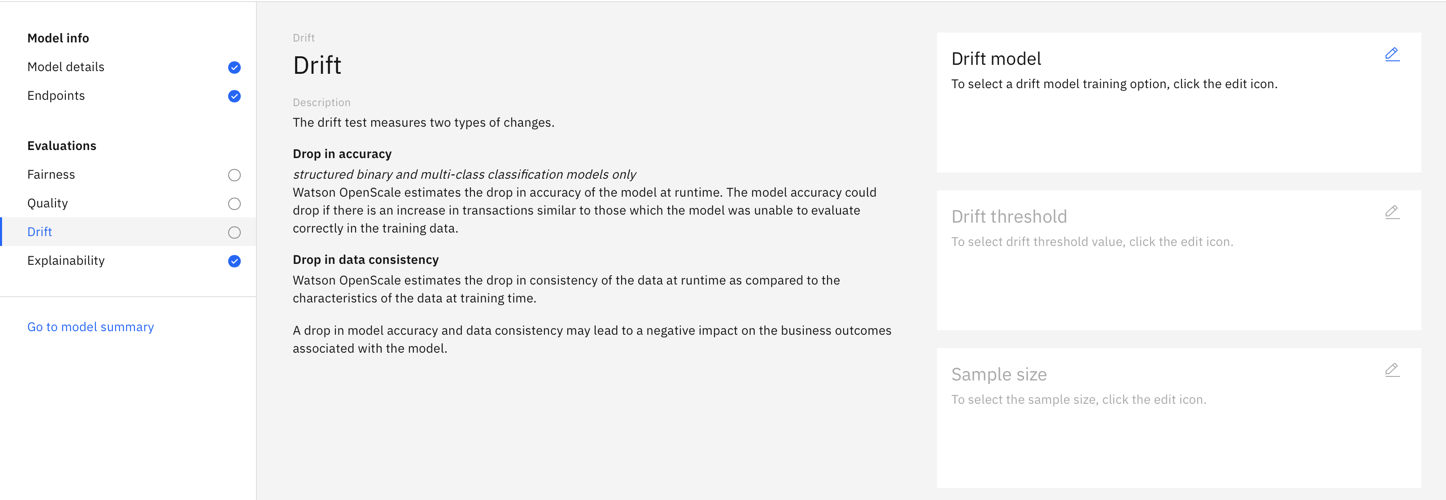


Select `Train in Watson OpenScale` and click next.

A drift alert threshold of 10% is the default. Lower values will make the system more sensitive to small amounts of drift, providing early warning of changes to data.

Click `Next`

Set the sample size to 500 and click `Next`

It may take ten to twenty minutes to configure and train the drift monitor.

## Deployment Monitoring

After the Drift monitor is trained, you can return to the IBM Watson OpenScale dashboard and monitor the performance of the model over time as additional transactions are made.

Note that quality and fairness metrics update once per hour and drift updates once every three hours. Here we will use the feature Evaluate now to create one evaluation point based on a static .csv file of simulated new data.

Before being able to feed our model with the new data we need to process it with the significant tf-idf vectorizer that we saved earlier in this notebook.

In [265]:
# Load new reviews
new_data = pd.read_csv(os.path.join(DATA_DIR, 'new_movie_reviews.csv'))

# Load the tfidf vecotrizer
with open('significant_tfidf.pkl', 'rb') as f:
    significant_tfidf = pickle.load(f)

# Preprocess the reviews
X_new_significant_tfidf = significant_tfidf.transform(new_data['review'].values)
X_new_significant_df = pd.DataFrame(X_new_significant_tfidf.toarray(), columns=significant_tfidf.get_feature_names(), index=new_data.index)

# Save the processed new data
pd.concat([X_new_significant_df, new_data['label']], axis =1).rename({'label' : '*label*'}, axis=1).to_csv(os.path.join(DATA_DIR, 'processed_new_data.csv'), index = False)

Returning to your OpenScale instance, click on `Dashboard` on the top left of your screen and click on the name of the model deployment that we just configured. 

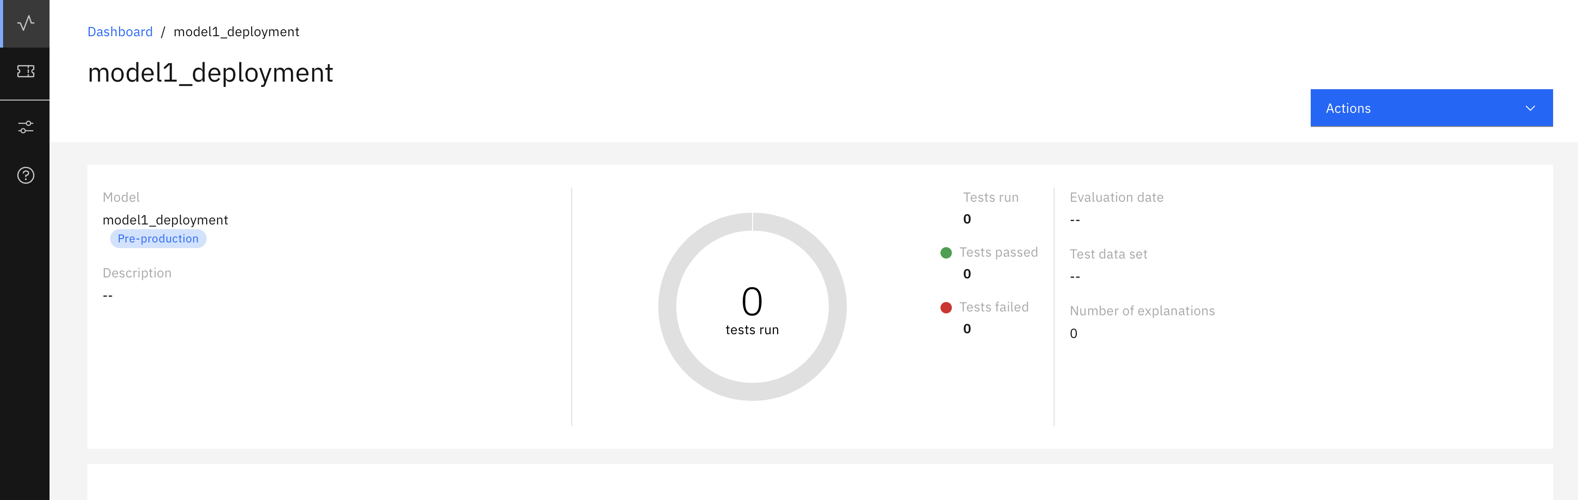

Click on `Action` and select `Evaluate Now`. Then, under import select `from CSV file`. Brows to your file system to select `processed_new_data.csv` and click `Upload and evaluate`.

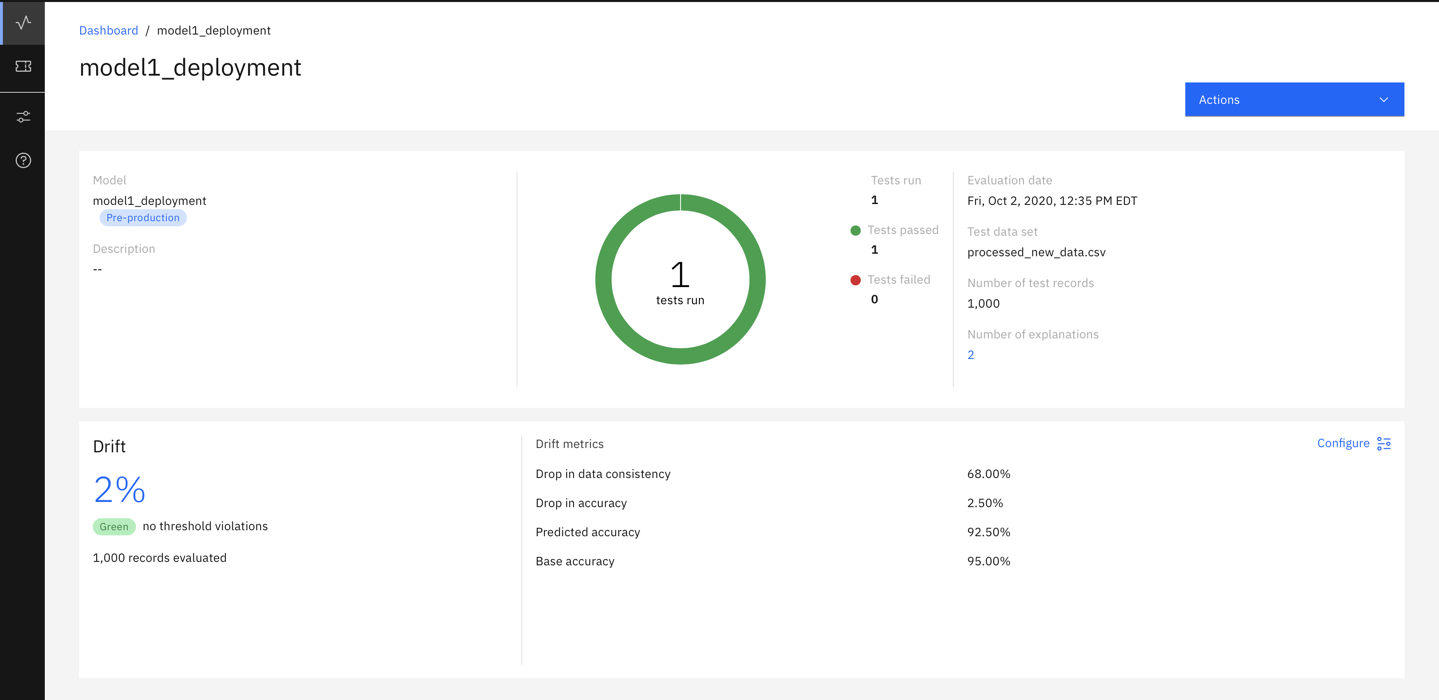

After several minutes you will see the results of the test for this first set of new data. New evaluations are done regularly based on the evaluation triggered on the endpoint of your deployment space. The Dashboard allows you to monitor the tests over time.

In this notebook we deployed a Text Classifier on Watson Machine Learning. Then, we configured an OpenScale instance to monitor the drift of our model. Finally we simulated a first evaluation point with some simulated new data. 

In order to experiment the full potential of OpenScale we would need to leave an active and used deployed model for several days or several weeks. We can obviously not create such a deployment in the context of this course so we invite you to look at the following link to see OpenScale's monitoring capabilities in a real deployment setting: https://www.ibm.com/demos/collection/IBM-Watson-OpenScale/